# Tutorial 2: Introduction to PyTorch

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=green)

**Filled notebook:** 
[![View filled on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial2/Introduction_to_PyTorch.ipynb)
[![Open filled In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial2/Introduction_to_PyTorch.ipynb)   
**Recordings:** 
[![YouTube - Part 1](https://img.shields.io/static/v1.svg?logo=youtube&label=YouTube&message=Part%201&color=red)](https://youtu.be/wnKZZgFQY-E)
[![YouTube - Part 2](https://img.shields.io/static/v1.svg?logo=youtube&label=YouTube&message=Part%202&color=red)](https://youtu.be/schbjeU5X2g)

Welcome to our PyTorch tutorial for the Deep Learning course 2021 at the University of Amsterdam! The following notebook is meant to give a short introduction to PyTorch basics, and get you setup for writing your own neural networks. PyTorch is an open source machine learning framework that allows you to write your own neural networks and optimize them efficiently. However, PyTorch is not the only framework of its kind. Alternatives to PyTorch include [TensorFlow](https://www.tensorflow.org/), [JAX](https://github.com/google/jax#quickstart-colab-in-the-cloud) and [Caffe](http://caffe.berkeleyvision.org/). We choose to teach PyTorch at the University of Amsterdam because it is well established, has a huge developer community (originally developed by Facebook), is very flexible and especially used in research. Many current papers publish their code in PyTorch, and thus it is good to be familiar with PyTorch as well. 
Meanwhile, TensorFlow (developed by Google) is usually known for being a production-grade deep learning library. Still, if you know one machine learning framework in depth, it is very easy to learn another one because many of them use the same concepts and ideas. For instance, TensorFlow's version 2 was heavily inspired by the most popular features of PyTorch, making the frameworks even more similar. 
If you are already familiar with PyTorch and have created your own neural network projects, feel free to just skim this notebook.

We are of course not the first ones to create a PyTorch tutorial. There are many great tutorials online, including the ["60-min blitz"](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) on the official [PyTorch website](https://pytorch.org/tutorials/). Yet, we choose to create our own tutorial which is designed to give you the basics particularly necessary for the practicals, but still understand how PyTorch works under the hood. Over the next few weeks, we will also keep exploring new PyTorch features in the series of Jupyter notebook tutorials about deep learning. 

We will use a set of standard libraries that are often used in machine learning projects. If you are running this notebook on Google Colab, all libraries should be pre-installed. If you are running this notebook locally, make sure you have installed our `dl2021` environment and have activated it.

In [41]:
## Standard libraries
import os
import math
import numpy as np 
import time

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
# from tqdm.notebook import tqdm

/tmp/ipykernel_34838/1106040074.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


## The Basics of PyTorch

We will start with reviewing the very basic concepts of PyTorch. As a prerequisite, we recommend to be familiar with the `numpy` package as most machine learning frameworks are based on very similar concepts. If you are not familiar with numpy yet, don't worry: here is a [tutorial](https://numpy.org/devdocs/user/quickstart.html) to go through. 

So, let's start with importing PyTorch. The package is called `torch`, based on its original framework [Torch](http://torch.ch/). As a first step, we can check its version:

In [42]:
import torch
print("Using torch", torch.__version__)

Using torch 1.8.1


At the time of writing this tutorial (mid of October 2021), the current stable version is 1.10. You should therefore see the output `Using torch 1.10.0` or `Using torch 1.9.0`, eventually with some extension for the CUDA version on Colab. In case you use the `dl2021` environment, you should see `Using torch 1.10.0`. In general, it is recommended to keep the PyTorch version updated to the newest one. If you see a lower version number than 1.9, make sure you have installed the correct the environment, or ask one of your TAs. In case PyTorch 1.11 or newer will be published during the time of the course, don't worry. The interface between PyTorch versions doesn't change too much, and hence all code should also be runnable with newer versions.

As in every machine learning framework, PyTorch provides functions that are stochastic like generating random numbers. However, a very good practice is to setup your code to be reproducible with the exact same random numbers. This is why we set a seed below. 

In [43]:
torch.manual_seed(42) # Setting the seed

In [44]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cpu


In [45]:
import torch.nn as nn

In [46]:
import torch.nn.functional as F

In [47]:
import torch.utils.data as data

class XORDataset(data.Dataset):

    def __init__(self, size, std=0.1):
        """
        Inputs:
            size - Number of data points we want to generate
            std - Standard deviation of the noise (see generate_continuous_xor function)
        """
        super().__init__()
        self.size = size
        self.std = std
        self.generate_continuous_xor()

    def generate_continuous_xor(self):
        # Each data point in the XOR dataset has two variables, x and y, that can be either 0 or 1
        # The label is their XOR combination, i.e. 1 if only x or only y is 1 while the other is 0.
        # If x=y, the label is 0.
        data = torch.randint(low=0, high=2, size=(self.size, 2), dtype=torch.float32)
        label = (data.sum(dim=1) == 1).to(torch.long)
        # To make it slightly more challenging, we add a bit of gaussian noise to the data points.
        data += self.std * torch.randn(data.shape)

        self.data = data
        self.label = label

    def __len__(self):
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return self.size

    def __getitem__(self, idx):
        # Return the idx-th data point of the dataset
        # If we have multiple things to return (data point and label), we can return them as tuple
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label



dataset = XORDataset(size=200, std = 0.2)
print("Size of dataset:", len(dataset))
print("Data point 0:", dataset[0])

data_loader = data.DataLoader(dataset, batch_size=8, shuffle=True)


train_dataset = XORDataset(size=2500, std = 0.2)
train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)

test_dataset = XORDataset(size=500, std = 0.2)
# drop_last -> Don't drop the last batch although it is smaller than 128
test_data_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False) 

Size of dataset: 200
Data point 0: (tensor([0.0049, 0.7872]), tensor(1))


In [48]:
class SimpleClassifier(nn.Module):

    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        # Initialize the modules we need to build the network
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.act_fn = nn.Tanh()
        self.linear2 = nn.Linear(num_hidden, num_outputs)

    def forward(self, x):
        # Perform the calculation of the model to determine the prediction
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.linear2(x)
        return x

loss_module = nn.BCEWithLogitsLoss()

In [49]:
def grad_data_inputs(model, data_inputs, data_labels, loss_module): #optimizer second arg
    data_inputs.requires_grad = True

    data_inputs_grad = torch.tensor(0.)
    
    preds = model(data_inputs)
    preds = preds.squeeze(dim=1)

    loss = loss_module(preds, data_labels.float())

    # optimizer.zero_grad()
    
    
    data_inputs_grad = torch.autograd.grad(loss, data_inputs)[0]
    data_inputs.requires_grad = False
    return data_inputs_grad


model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

for data_inputs, data_labels in data_loader:
    grad = grad_data_inputs(model, data_inputs, data_labels, loss_module)
    print(f'{grad = }')
    break

grad = tensor([[ 1.7623e-02, -1.5244e-02],
        [-9.8924e-03,  8.9022e-04],
        [-1.1878e-02, -1.6864e-03],
        [ 1.7335e-02, -1.4409e-02],
        [-1.3293e-02, -5.4011e-05],
        [-1.2843e-02,  4.2515e-03],
        [-1.1416e-02, -1.1335e-04],
        [ 2.7486e-02,  4.0557e-03]])


The train_model function allows to add an augmented loss term that is given by the gradient of the original loss with respect to the input.
The goal is to make the model more robust with respect to perturbations.

In [50]:

def train_model(model, optimizer, data_loader, loss_module, num_epochs=100, eps = 0):
    # Set model to train mode
    model.train() 
    
    # Training loop
    for epoch in range(num_epochs):
        for data_inputs, data_labels in data_loader:
            
            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)
            
            ## Step 2: Run the model on the input data
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]
            
            #AUGMENTATION OF LOSS FUNCTION
            #if eps > 0 the gradient of the loss function with respect to changes of the input data is added to the loss function
            if eps > 0:
                grad = grad_data_inputs(model, data_inputs, data_labels, loss_module)

                loss = (1- eps)*loss_module(preds, data_labels.float()) + eps * grad.abs().sum()
            else:
            ## Step 3: Calculate the loss
                loss = loss_module(preds, data_labels.float())
                
            ## Step 4: Perform backpropagation
            # Before calculating the gradients, we need to ensure that they are all zero. 
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad() 
            # Perform backpropagation
            loss.backward()
            
            ## Step 5: Update the parameters
            optimizer.step()


As a comparison we also implement the Fast Gradient Sign Method (FGSM) that augments the original loss function by adding a term that evaluates the loss function not at the input term but the input term changed in the direction of the sign of the loss gradient with respect to the input (which constitutes the worst case direction with infinity norm loss of size 1)

In [51]:
def train_FGSM(model, optimizer, data_loader, loss_module, num_epochs=100, eps = 0):
    # Set model to train mode
    model.train() 
    
    # Training loop
    for epoch in range(num_epochs):
        for data_inputs, data_labels in data_loader:
            
            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)
            
            ## Step 2: Run the model on the input data
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]
            
            #AUGMENTATION OF LOSS FUNCTION
            #if eps > 0 the gradient of the loss function with respect to changes of the input data is added to the loss function
            if eps > 0:
                grad = grad_data_inputs(model, data_inputs, data_labels, loss_module)
                grad = grad.sign()
                preds_eps = model(data_inputs + eps * grad)
                preds_eps = preds_eps.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]
           
                loss = (1- eps)*loss_module(preds, data_labels.float()) + eps * loss_module(preds_eps, data_labels.float())
            else:
            ## Step 3: Calculate the loss
                loss = loss_module(preds, data_labels.float())
                
            ## Step 4: Perform backpropagation
            # Before calculating the gradients, we need to ensure that they are all zero. 
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad() 
            # Perform backpropagation
            loss.backward()
            
            ## Step 5: Update the parameters
            optimizer.step()

In [52]:

model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
train_FGSM(model, optimizer, train_data_loader, loss_module, eps = 0)


In [53]:
def eval_model(model, data_loader):
    model.eval() # Set model to eval mode
    true_preds, num_preds = 0., 0.
    
    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs, data_labels in data_loader:
            
            # Determine prediction of model on dev set
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)
            preds = torch.sigmoid(preds) # Sigmoid to map predictions between 0 and 1
            pred_labels = (preds >= 0.5).long() # Binarize predictions to 0 and 1
            
            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_labels).sum()
            num_preds += data_labels.shape[0]
            
    acc = true_preds / num_preds
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")

In [54]:
eval_model(model, test_data_loader)

Accuracy of the model: 97.40%


preds.size() = torch.Size([200, 200, 1])


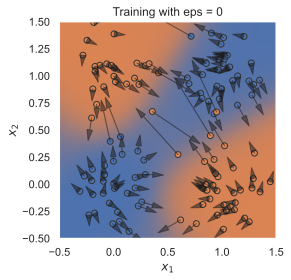

In [55]:



@torch.no_grad() # Decorator, same effect as "with torch.no_grad(): ..." over the whole function.
def visualize_classification(model, data, label, grad, eps = 0):

    

    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    
    
    
    fig = plt.figure(figsize=(4,4), dpi=500)
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Training with eps = {}".format(eps))
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    # plt.legend()

    for i in range(len(data[:,0])):
            plt.arrow(data[i, 0], data[i, 1], grad[i, 0], grad[i, 1], head_width=0.05, head_length=0.1, fc='k', ec='k', alpha = 0.5)
    
    # Let's make use of a lot of operations we have learned above
    model.to(device)
    c0 = torch.Tensor(to_rgba("C0")).to(device)
    c1 = torch.Tensor(to_rgba("C1")).to(device)
    x1 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    x2 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    xx1, xx2 = torch.meshgrid(x1, x2)  # Meshgrid function as in numpy
    model_inputs = torch.stack([xx1, xx2], dim=-1)
    preds = model(model_inputs)
    preds = torch.sigmoid(preds)
    print(f'{preds.size() = }')

    output_image = (1 - preds) * c0[None,None] + preds * c1[None,None]  # Specifying "None" in a dimension creates a new one
    output_image = output_image.cpu().numpy()  # Convert to numpy array. This only works for tensors on CPU, hence first push to CPU
    plt.imshow(output_image, origin='lower', extent=(-0.5, 1.5, -0.5, 1.5))
    plt.grid(False)
    return fig


for input_data, label in test_data_loader:
    grad = grad_data_inputs(model, input_data, label, loss_module)
    visualize_classification(model, input_data, label, 10*grad)
    break

plt.show()

In [56]:
eps = [0, 0.3, 0.5, 0.6]

for eps_value in eps:
    model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    train_model(model, optimizer, train_data_loader, loss_module, eps = eps_value)

    for input_data, label in test_data_loader:
        grad = grad_data_inputs(model, input_data, label, loss_module)
        visualize_classification(model, input_data, label, 10*grad, eps_value)
        break

plt.show()

preds.size() = torch.Size([200, 200, 1])
preds.size() = torch.Size([200, 200, 1])


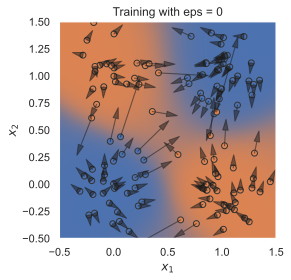

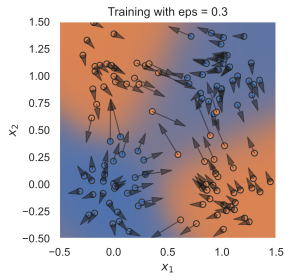

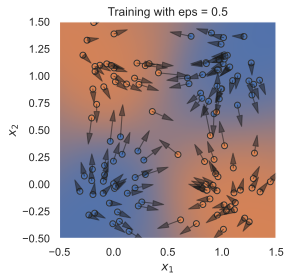

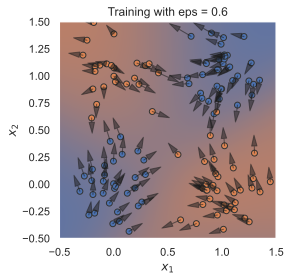

In [ ]:
eps = [0, 0.3, 0.5, 0.6]

for eps_value in eps:
    model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    train_FGSM(model, optimizer, train_data_loader, loss_module, eps = eps_value)

    for input_data, label in test_data_loader:
        grad = grad_data_inputs(model, input_data, label, loss_module)
        visualize_classification(model, input_data, label, 10*grad, eps_value)
        break

plt.show()

The decision boundaries might not look exactly as in the figure in the preamble of this section which can be caused by running it on CPU or a different GPU architecture. Nevertheless, the result on the accuracy metric should be the approximately the same. 

## Additional features we didn't get to discuss yet

Finally, you are all set to start with your own PyTorch project! In summary, we have looked at how we can build neural networks in PyTorch, and train and test them on data. However, there is still much more to PyTorch we haven't discussed yet. In the comming series of Jupyter notebooks, we will discover more and more functionalities of PyTorch, so that you also get familiar to PyTorch concepts beyond the basics. If you are already interested in learning more of PyTorch, we recommend the official [tutorial website](https://pytorch.org/tutorials/) that contains many tutorials on various topics. Especially logging with Tensorboard ([official tutorial here](https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html)) is a good practice that we will explore further from Tutorial 5 on in combination with PyTorch Lightning.
Nonetheless, let's check it shortly out how we could use TensorBoard in our small example.

### TensorBoard logging

TensorBoard is a logging and visualization tool that is a popular choice for training deep learning models. Although initially published for TensorFlow, TensorBoard is also integrated in PyTorch allowing us to easily use it. First, let's import it below.

In [ ]:
# Import tensorboard logger from PyTorch
from torch.utils.tensorboard import SummaryWriter

# Load tensorboard extension for Jupyter Notebook, only need to start TB in the notebook
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


The last line is required if you want to run TensorBoard directly in the Jupyter Notebook. Otherwise, you can start TensorBoard from the terminal.

PyTorch's TensorBoard API is simple to use. We start the logging process by creating a new object, `writer = SummaryWriter(...)`, where we specify the directory in which the logging file should be saved. With this object, we can log different aspects of our model by calling functions of the style `writer.add_...`. For example, we can visualize the computation graph with the function `writer.add_graph`, or add a scalar value like the loss with `writer.add_scalar`. Let's adapt our initial training function with adding a TensorBoard logger below.

In [ ]:
def train_model_with_logger(model, optimizer, data_loader, loss_module, val_dataset, num_epochs=100, logging_dir='runs/our_experiment'):
    # Create TensorBoard logger
    writer = SummaryWriter(logging_dir)
    model_plotted = False
    
    # Set model to train mode
    model.train() 
    
    # Training loop
    for epoch in tqdm(range(num_epochs)):
        epoch_loss = 0.0
        for data_inputs, data_labels in data_loader:
            
            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)
            
            # For the very first batch, we visualize the computation graph in TensorBoard
            if not model_plotted:
                writer.add_graph(model, data_inputs)
                model_plotted = True
            
            ## Step 2: Run the model on the input data
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]
            
            ## Step 3: Calculate the loss
            loss = loss_module(preds, data_labels.float())
            
            ## Step 4: Perform backpropagation
            # Before calculating the gradients, we need to ensure that they are all zero. 
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad() 
            # Perform backpropagation
            loss.backward()
            
            ## Step 5: Update the parameters
            optimizer.step()
            
            ## Step 6: Take the running average of the loss
            epoch_loss += loss.item()
            
        # Add average loss to TensorBoard
        epoch_loss /= len(data_loader)
        writer.add_scalar('training_loss',
                          epoch_loss,
                          global_step = epoch + 1)
        
        # Visualize prediction and add figure to TensorBoard
        # Since matplotlib figures can be slow in rendering, we only do it every 10th epoch
        if (epoch + 1) % 10 == 0:
            fig = visualize_classification(model, val_dataset.data, val_dataset.label)
            writer.add_figure('predictions',
                              fig,
                              global_step = epoch + 1)
    
    writer.close()

Let's use this method to train a model as before, with a new model and optimizer.

In [ ]:
model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
train_model_with_logger(model, optimizer, train_data_loader, loss_module, val_dataset=dataset)

NameError: name 'tqdm' is not defined

The TensorBoard file in the folder `runs/our_experiment` now contains a loss curve, the computation graph of our network, and a visualization of the learned predictions over number of epochs. To start the TensorBoard visualizer, simply run the following statement:

In [ ]:
%tensorboard --logdir runs/our_experiment

<center><img src="tensorboard_screenshot.png" width="1100px"></center>

TensorBoard visualizations can help to identify possible issues with your model, and identify situations such as overfitting. You can also track the training progress while a model is training, since the logger automatically writes everything added to it to the logging file. Feel free to explore the TensorBoard functionalities, and we will make use of TensorBoards a couple of times from Tutorial 5 on.